In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_ind
from scipy import stats



In [2]:
errands_df = pd.read_parquet('Data/errands.parquet')
orders_df = pd.read_parquet('Data/orders.parquet')

In [3]:
errands_df = errands_df[errands_df['is_test_errand'] != 1]


In [4]:
currency_name_to_code = {
    'Euro': 'EUR',
    'Australian Dollar': 'AUD',
    'Brazilian Real': 'BRL',
    'US Dollar': 'USD',
    'Danish Krone': 'DKK',
    'Saudi Riyal': 'SAR',
    'Mexican Peso': 'MXN',
    'Pound Sterling': 'GBP',
    'Zloty': 'PLN',
    'Norwegian Krone': 'NOK',
    'Canadian Dollar': 'CAD',
    'United Arab Emirates dirham': 'AED',
    'Swedish Krona': 'SEK',
    'Chilean Peso': 'CLP',
    'Peso Uruguayo': 'UYU',
    'Nuevo Sol Peru': 'PEN',
    'South Korean Won': 'KRW',
    'Malaysian Ringgit': 'MYR',
    'Argentine Peso': 'ARS',
    'Thai Baht': 'THB',
    'Czech Koruna': 'CZK',
    'Colombian Peso Colombia': 'COP',
    'Kuwaiti Dinar': 'KWD',
    'Swiss Franc': 'CHF',
    'Hryvnia Ukraine': 'UAH',
    'South African Rand': 'ZAR',
    'Japanese yen': 'JPY',
    'Jordanian Dinar': 'JOD',
    'Bahraini Dinar': 'BHD',
    'New Zealand Dollar': 'NZD',
    'Indian Rupee': 'INR',
    'Egyptian Pound': 'EGP',
    'Bulgarian Lev': 'BGN',
    'Rupiah Indonesia': 'IDR',
    'Turkish Lira': 'TRY',
    'Qatari Rial': 'QAR',
    'Singapore Dollar': 'SGD',
    'Hong Kong Dollar': 'HKD',
    'Philippine Peso': 'PHP',
    'New Taiwan Dollar': 'TWD',
    'Rial Omani Oman': 'OMR',
    'Forint': 'HUF',
    'Yuan Renminbi': 'CNY',
    'Vietnamese dong': 'VND',
    'Iceland Krona': 'ISK',
    'Tenge Kazakhstan': 'KZT',
    'Uzbekistan Som': 'UZS'
}
#Static exchange rate, in actual analysis it has to be updated so it uses API, easy-exchange-rates and forex-python has been tried so far, 
#Read their documentationss to see why the exchange has problems. 
exchange_rates_to_usd = {
    'USD': 1,
    'EUR': 1.08,
    'AUD': 0.64,
    'BRL': 0.19,
    'DKK': 0.14,
    'SAR': 0.27,
    'MXN': 0.052,
    'GBP': 1.37,
    'PLN': 0.26,
    'NOK': 0.11,
    'CAD': 0.75,
    'AED': 0.27,
    'SEK': 0.095,
    'CLP': 0.0012,
    'UYU': 0.023,
    'PEN': 0.27,
    'KRW': 0.00076,
    'MYR': 0.23,
    'ARS': 0.010,
    'THB': 0.032,
    'CZK': 0.048,
    'COP': 0.00026,
    'KWD': 3.28,
    'CHF': 1.09,
    'UAH': 0.036,
    'ZAR': 0.055,
    'JPY': 0.0074,
    'JOD': 1.41,
    'BHD': 2.65,
    'NZD': 0.63,
    'INR': 0.013,
    'EGP': 0.032,
    'BGN': 0.58,
    'IDR': 0.000066,
    'TRY': 0.054,
    'QAR': 0.27,
    'SGD': 0.74,
    'HKD': 0.13,
    'PHP': 0.018,
    'TWD': 0.032,
    'OMR': 2.60,
    'HUF': 0.0031,
    'CNY': 0.15,
    'VND': 0.000043,
    'ISK': 0.0075,
    'KZT': 0.0023,
    'UZS': 0.000091
}



def convert_prices_to_usd(df):
    
    df['currency_code'] = df['currency'].map(currency_name_to_code)

    currency_index = df.columns.get_loc('currency')  
    df.insert(currency_index + 1, 'currency_code', df.pop('currency_code'))

    unmapped = df[df['currency_code'].isna()]['currency'].unique()
    if len(unmapped) > 0:
        print("Unmapped currencies:", unmapped)

    
    df['Order_Amount_in_usd'] = df.apply(
        lambda row: row['Order_Amount'] * exchange_rates_to_usd.get(row['currency_code'], 0) if row['currency_code'] in exchange_rates_to_usd else 0,
        axis=1
    )
    
    price_index = df.columns.get_loc('Order_Amount')
    df.insert(price_index + 1, 'Order_Amount_in_usd', df.pop('Order_Amount_in_usd'))

    df['Revenue_in_usd'] = df.apply(
        lambda row: row['Revenue'] * exchange_rates_to_usd.get(row['currency_code'], 0) if row['currency_code'] in exchange_rates_to_usd else 0,
        axis=1
    )
    
    price_index = df.columns.get_loc('Revenue')
    df.insert(price_index + 1, 'Revenue_in_usd', df.pop('Revenue_in_usd'))

    return df


orders_df = convert_prices_to_usd(orders_df)

In [19]:
orders_df['order_created_at'] = pd.to_datetime(orders_df['order_created_at'])
errands_df['created'] = pd.to_datetime(errands_df['created'])#.dt.date
errands_df['order_number'] = errands_df['order_number'].apply(lambda x: int(x, 36))
errands_df = errands_df.rename(columns={'order_number' : 'order_id'})

In [6]:
merged_df = pd.merge(orders_df, errands_df, on='order_id', how='inner')

In [7]:
merged_df['order_created_at'] = pd.to_datetime(merged_df['order_created_at'])#.dt.date
merged_df['created'] = pd.to_datetime(merged_df['created'])#.dt.date

# date_columns = ['created', 'order_created_at']

# for col in date_columns:
#     merged_df[col] = pd.to_datetime(merged_df[col]) 
#     merged_df[f'{col}_YearMonth'] = merged_df[col].dt.to_period('M')
    
#     # Get the index of the original column and move the new column
#     col_index = merged_df.columns.get_loc(col)
#     merged_df.insert(col_index + 1, f'{col}_YearMonth', merged_df.pop(f'{col}_YearMonth'))
    
    
#     merged_df.drop(col, axis=1, inplace=True)

count    2.680892e+06
mean     3.292337e+05
std      3.795246e+05
min     -1.615593e+04
25%      3.430720e+04
50%      1.815909e+05
75%      5.001733e+05
max      2.028768e+06
Name: Time_diff, dtype: float64


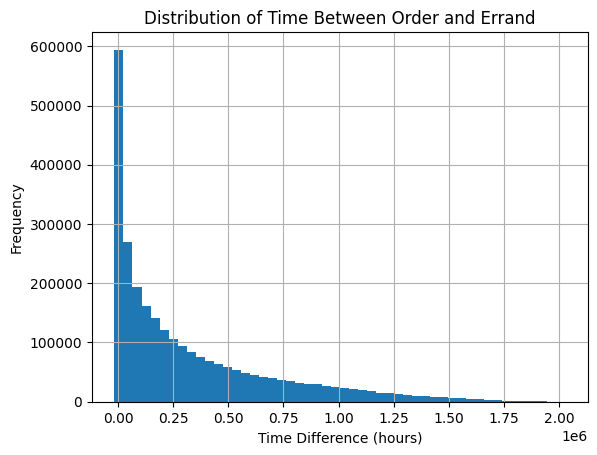

In [63]:
merged_df['Time_diff'] = ((merged_df['created'] - merged_df['order_created_at']).dt.total_seconds()) / 360*24

time_diff_stats = merged_df['Time_diff'].describe()
print(time_diff_stats)

merged_df['Time_diff'].hist(bins=50)
plt.title("Distribution of Time Between Order and Errand")
plt.xlabel("Time Difference (hours)")
plt.ylabel("Frequency")
plt.show()



In [64]:
merged_df['Time_diff_weeks'] = merged_df['Time_diff'] / ( 7) 
later_df = merged_df[merged_df['Time_diff_weeks'] > 1]

top_10_errands = later_df['errand_category'].value_counts().head(1)

top_10_errands_detailed = later_df.groupby('errand_category')['errand_type'].value_counts().head(1)

filtered_df = merged_df[merged_df['Time_diff_weeks'] < 1]

top_10 = filtered_df['errand_category'].value_counts().head(1)

top_10_detailed = filtered_df.groupby('errand_category')['errand_type'].value_counts().head(1)

print(f"Top 10 Errand Categories when time difference > 1 week: {top_10_errands}")
print(f"Top 10 Errand Categories when time difference < 1 week: {top_10}")

print(f"\nTop 10 Errand Types within each Category when time difference > 1 week: {top_10_errands_detailed}")
print(f"\nTop 10 Errand Types within each Category when time difference < 1 week: {top_10_detailed}")

Top 10 Errand Categories when time difference > 1 week: errand_category
2: Cancellation / refund    650562
Name: count, dtype: int64
Top 10 Errand Categories when time difference < 1 week: errand_category
6: Payment questions    1729
Name: count, dtype: int64

Top 10 Errand Types within each Category when time difference > 1 week: errand_category    errand_type
10: Force Majeure  2: Cancel      3503
Name: count, dtype: int64

Top 10 Errand Types within each Category when time difference < 1 week: errand_category   errand_type                             
11: Site support  1. No booking - general ETG site support    32
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

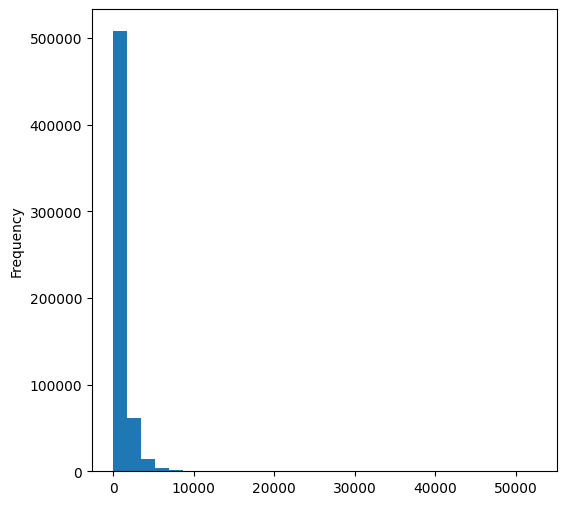

In [10]:
canceled_orders = merged_df[merged_df['Is_Canceled'] == 1]
# canceled_orders.plot(kind='box', y='Order_Amount_in_usd', figsize=(6,6))
# sns.violinplot(x='Is_Canceled', y='Order_Amount_in_usd', data=merged_df)
canceled_orders['Order_Amount_in_usd'].plot(kind='hist', bins=30, figsize=(6,6))



In [11]:
errand_counts = merged_df.groupby('order_id').size().reset_index(name='errand_Count')

orders_with_errands = pd.merge(orders_df, errand_counts, on='order_id', how='left')

orders_with_errands['errand_Count'] = orders_with_errands['errand_Count'].fillna(0)

In [12]:
# # Define quantiles for categorization
# orders_with_errands['Order_Value_Category'] = pd.qcut(
#     orders_with_errands['Order_Amount_in_usd'], 
#     q=3,  # Change to 4 for quartiles or custom thresholds
#     labels=['Low', 'Medium', 'High']
# )


bins = [0, 100, 500, 1000, 5000, float('inf')]  
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

orders_with_errands['Order_Value_Category'] = pd.cut(
    orders_with_errands['Order_Amount_in_usd'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

In [13]:
value_analysis = orders_with_errands.groupby('Order_Value_Category').agg(
    Avg_Errand_Count=('errand_Count', 'mean'),
    Proportion_With_Errands=('errand_Count', lambda x: (x > 0).mean())
).reset_index()


/var/folders/_6/f4xb86d93znb83vn6wy29k2r0000gn/T/ipykernel_23522/193485439.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  value_analysis = orders_with_errands.groupby('Order_Value_Category').agg(


In [14]:

contingency_table = pd.crosstab(orders_with_errands['Order_Value_Category'], orders_with_errands['errand_Count'] > 0)
chi2, p, _, _ = chi2_contingency(contingency_table)

with_errands = orders_with_errands[orders_with_errands['errand_Count'] > 0]['Order_Amount_in_usd']
without_errands = orders_with_errands[orders_with_errands['errand_Count'] == 0]['Order_Amount_in_usd']
t_stat, p_val = ttest_ind(with_errands, without_errands, equal_var=False)


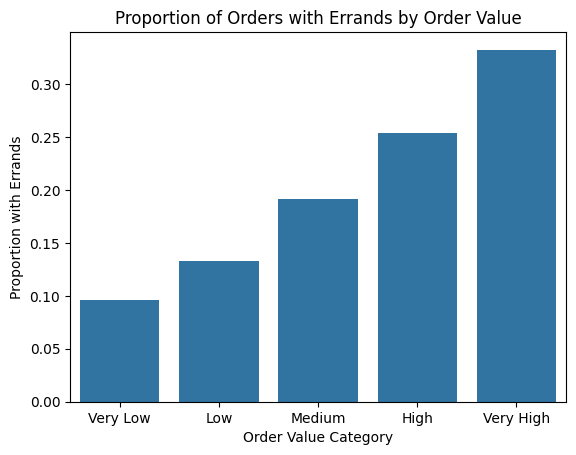

In [15]:
sns.barplot(
    data=value_analysis, 
    x='Order_Value_Category', 
    y='Proportion_With_Errands'
)
plt.title('Proportion of Orders with Errands by Order Value')
plt.ylabel('Proportion with Errands')
plt.xlabel('Order Value Category')
plt.show()

In [65]:
merged_df.columns

Index(['order_id', 'PNR', 'order_created_at', 'booking_system', 'Site_Country',
       'Brand', 'Order_Amount', 'Order_Amount_in_usd', 'currency',
       'currency_code', 'Revenue', 'Revenue_in_usd', 'Partner',
       'Customer_Group_Type', 'Device', 'client_entry_type',
       'booking_system_source_type', 'Origin_Country', 'Destination_Country',
       'Journey_Type_ID', 'Is_Changed', 'Is_Canceled', 'cancel_reason',
       'change_reason', 'errand_id', 'created', 'errand_category',
       'errand_type', 'errand_action', 'errand_channel', 'is_test_errand',
       'Time_diff', 'Time_diff_weeks'],
      dtype='object')

   Site_Country  Errand_Count  Order_Count  Errand_Rate
45      Nigeria          1303         1301     1.001537
31       Israel         32699        37870     0.863454
10        China          3374         4938     0.683273
36        Korea         67688       100016     0.676772
0     Argentina          6575        10059     0.653644
6        Brazil        151257       242003     0.625021
70      Uruguay           708         1180     0.600000
44  New Zealand         15759        27015     0.583343
13         Cuba          8234        14443     0.570103
8        Canada        100763       176882     0.569662


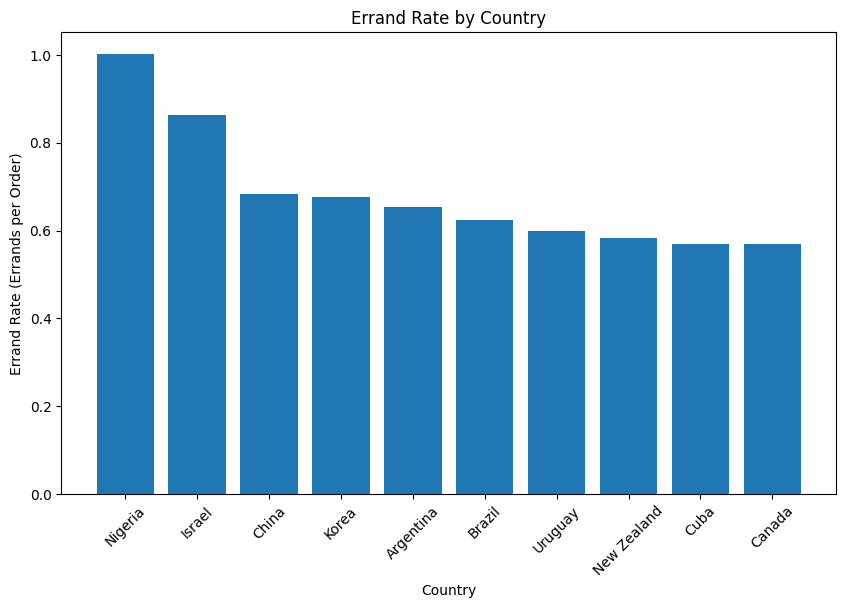

In [69]:
df = pd.merge(errands_df, orders_df, on='order_id', how='left')

currency_errands = df.groupby('Site_Country').size().reset_index(name='Errand_Count')

orders_per_currency = orders_df.groupby('Site_Country').size().reset_index(name='Order_Count')

currency_analysis = pd.merge(currency_errands, orders_per_currency, on='Site_Country', how='left')


currency_analysis['Errand_Rate'] = currency_analysis['Errand_Count'] / currency_analysis['Order_Count']

currency_analysis_sorted = currency_analysis.sort_values(by='Errand_Rate', ascending=False).head(10)

print(currency_analysis_sorted)

plt.figure(figsize=(10, 6))
plt.bar(currency_analysis_sorted['Site_Country'], currency_analysis_sorted['Errand_Rate'])
plt.xlabel('Country')
plt.ylabel('Errand Rate (Errands per Order)')
plt.title('Errand Rate by Country')
plt.xticks(rotation=45)
plt.show()

### Check if errands are more frequent for certain origin-destination pairs.

In [17]:
errand_counts = merged_df.groupby(['Origin_Country', 'Destination_Country']).size().reset_index(name='Errand_Count')

order_counts = orders_df.groupby(['Origin_Country', 'Destination_Country']).size().reset_index(name='Order_Count')
merged_counts = pd.merge(errand_counts, order_counts, on=['Origin_Country', 'Destination_Country'])

merged_counts['Errand_Per_Order'] = merged_counts['Errand_Count'] / merged_counts['Order_Count']

merged_counts_sorted = merged_counts.sort_values(by='Errand_Per_Order', ascending=False)


merged_counts_sorted

,Origin_Country,Destination_Country,Errand_Count,Order_Count,Errand_Per_Order
985,Bolivia,United Arab Emirates,43,1,43.000000
6112,Macau,Panama,24,1,24.000000
103,Angola,Georgia,47,2,23.500000
1714,Chile,Antigua and Barbuda,23,1,23.000000
4901,Israel,Venezuela,23,1,23.000000
...,...,...,...,...,...
6809,Montenegro,Netherlands,1,41,0.024390
2370,Cyprus,Malta,1,41,0.024390
6154,Macedonia,Poland,1,43,0.023256
10691,Uganda,Jordan,1,45,0.022222


In [18]:
journey_types = ['One-way', 'Round-trip', 'OpenJawSingleOrigin', 'MultiStop',
       'OpenJawSingleDestination', 'OpenJawDouble'] 
filtered_df = merged_df[merged_df['Journey_Type_ID'].isin(journey_types)]

errands_count = filtered_df.groupby('order_id')['errand_id'].count().reset_index()
errands_count.rename(columns={'errand_id': 'Errand_count'}, inplace=True)

final_df = pd.merge(filtered_df, errands_count, on='order_id', how='left')

journey_analysis = final_df.groupby('Journey_Type_ID')['Errand_count'].mean().reset_index()

one_way_data = final_df[final_df['Journey_Type_ID'] == 'One-way']['Errand_count']
round_trip_data = final_df[final_df['Journey_Type_ID'] == 'Round-trip']['Errand_count']
multi_city_data = final_df[final_df['Journey_Type_ID'] == 'MultiStop']['Errand_count']

anova_result = stats.f_oneway(one_way_data, round_trip_data, multi_city_data)

print(journey_analysis)
print(f"ANOVA test result: F-statistic={anova_result.statistic}, p-value={anova_result.pvalue}")


            Journey_Type_ID  Errand_count
0                 MultiStop      8.991261
1                   One-way      5.887160
2             OpenJawDouble      7.948109
3  OpenJawSingleDestination      7.352218
4       OpenJawSingleOrigin      8.842552
5                Round-trip      6.756410
ANOVA test result: F-statistic=4322.558111939577, p-value=0.0


In [26]:
merged_df.columns

Index(['order_id', 'PNR', 'order_created_at', 'booking_system', 'Site_Country',
       'Brand', 'Order_Amount', 'Order_Amount_in_usd', 'currency',
       'currency_code', 'Revenue', 'Revenue_in_usd', 'Partner',
       'Customer_Group_Type', 'Device', 'client_entry_type',
       'booking_system_source_type', 'Origin_Country', 'Destination_Country',
       'Journey_Type_ID', 'Is_Changed', 'Is_Canceled', 'cancel_reason',
       'change_reason', 'errand_id', 'created', 'errand_category',
       'errand_type', 'errand_action', 'errand_channel', 'is_test_errand',
       'Time_diff', 'Time_diff_weeks'],
      dtype='object')

In [53]:
family_changes = merged_df[(merged_df['Customer_Group_Type'] =='FAMILY')]
# group_changes = merged_df[(merged_df['Is_Changed'] == 1 ) & (merged_df['Is_Canceled'] == 0 )]

# groupchanges = group_changes.groupby(['Customer_Group_Type', 'errand_type']).size().reset_index(name= 'Count').sort_values(by='Count', ascending=False)
familyChanges = family_changes.groupby('errand_category').size().reset_index(name= 'Count').sort_values(by='Count', ascending=False)
changes_by_category = family_changes.groupby('errand_type').size().reset_index(name='Count').sort_values(by='Count', ascending=False)

familyChanges.head()

,errand_category,Count
15,2: Cancellation / refund,89846
6,18: Schedule change,80723
7,1: Rebooking,78190
34,5: Document & travel info,50149
29,4: Change of name & passenger info,38290


In [24]:
merged_df['Customer_Group_Type'].unique()

array(['SINGLE', 'COUPLE', 'FAMILY', 'GROUP'], dtype=object)

In [33]:
main_changes = merged_df[(merged_df['Is_Changed'] == 1 ) & (merged_df['Is_Canceled'] == 0 )]
changes_by_type = main_changes.groupby('errand_type').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
changes_by_category = main_changes.groupby('errand_category').size().reset_index(name='Count').sort_values(by='Count', ascending=False)

print(changes_by_type.head())
changes_by_category.head()

                   errand_type   Count
56       1: No Flexible Ticket  181631
98    2: We have inf. about SC  108728
40     1: Ask about cxnl rules   74115
79  2: Against Flexible Ticket   62805
55          1: Name correction   40695


,errand_category,Count
5,1: Rebooking,267340
4,18: Schedule change,204321
14,2: Cancellation / refund,119731
37,5: Document & travel info,58159
30,4: Change of name & passenger info,54939


In [45]:
main_canceled = merged_df[(merged_df['errand_category'] == '2: Cancellation / refund') ]
canceled_by_type = main_canceled.groupby('errand_type').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
canceled_by_type.head()


,errand_type,Count
8,1: Ask about cxnl rules,450383
13,2: Already cxnl,145943
5,16: Incorrect department-SC,19587
6,17: Already handled,16516
7,18: Incorrect department,9005


In [44]:
errand_category = merged_df.groupby('errand_category').size().reset_index(name='Count').sort_values(by='Count', ascending=False)
errand_category


,errand_category,Count
16,2: Cancellation / refund,650659
7,1: Rebooking,624523
6,18: Schedule change,457044
40,5: Document & travel info,324104
32,4: Change of name & passenger info,176551
26,43: No response,136635
42,7: Baggage,131324
41,6: Payment questions,46100
43,8: Seating,42053
44,9: Other services / products,38980


In [38]:
main_canceled.columns

Index(['order_id', 'PNR', 'order_created_at', 'booking_system', 'Site_Country',
       'Brand', 'Order_Amount', 'Order_Amount_in_usd', 'currency',
       'currency_code', 'Revenue', 'Revenue_in_usd', 'Partner',
       'Customer_Group_Type', 'Device', 'client_entry_type',
       'booking_system_source_type', 'Origin_Country', 'Destination_Country',
       'Journey_Type_ID', 'Is_Changed', 'Is_Canceled', 'cancel_reason',
       'change_reason', 'errand_id', 'created', 'errand_category',
       'errand_type', 'errand_action', 'errand_channel', 'is_test_errand',
       'Time_diff', 'Time_diff_weeks'],
      dtype='object')

In [43]:
X = merged_df[merged_df['Is_Canceled'] == 1]
X['errand_category'].unique()

array(['2: Cancellation / refund', '43: No response', '1: Rebooking',
       '9: Other services / products', '18: Schedule change',
       '8: Seating', '5: Document & travel info', '32: P&F Chargeback',
       '14: FL Fraud errands process',
       '4: Change of name & passenger info', '10: Force Majeure',
       '7: Baggage', '41: Call disconnected', '6: Payment questions',
       '11: Site support', '3: Claim wrong itinerary/dupe',
       '46: No information provided', '13: Language problem',
       '20: Ancillary team', '25: Other Booking.com products',
       '42: Customer feedback', '24: Accommodation ',
       '54: Claim form sent', '29: Leaders', '34: Backend BOM',
       '22: Backend ATH', '49: FL/SC OUT Support',
       '44: Payouts & Accounting', '31: P&F Fraud', '16: Backend UPA',
       '26: Booking.com phase 1 - No order in Edvin',
       '36: ETG Escalation', '53: Retail Loss', '40: Backend BOM TKT',
       '23: Legal and Authority Claims Team', '51. Backend FOP',
      

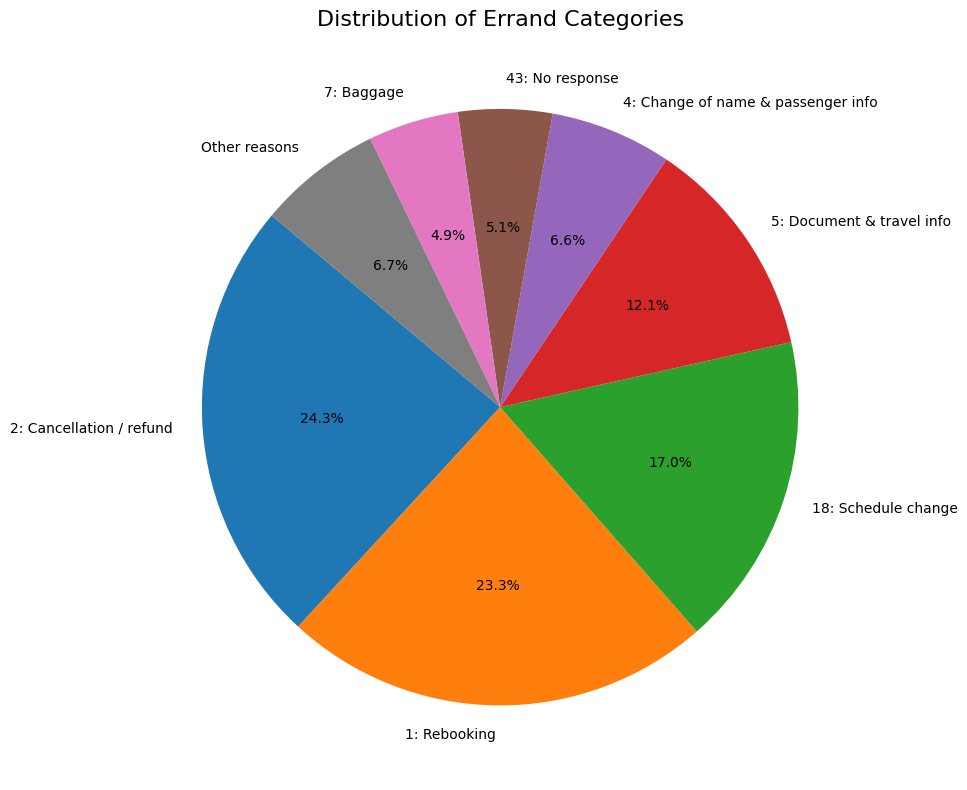

In [55]:
canceled_value_counts = merged_df['errand_category'].value_counts()
threshold = canceled_value_counts.sum() * 0.02
canceled_counts = canceled_value_counts[canceled_value_counts > threshold]
other_count = merged_df[ ~merged_df['errand_category'].isin(canceled_counts.index)]['errand_category'].count()
canceled_counts['Other reasons'] = other_count
canceled_counts['Other reasons']

plt.figure(figsize=(10, 8))
canceled_counts.plot(
    kind='pie', 
    autopct='%1.1f%%',  
    startangle=140,     
    legend=False
)

plt.title('Distribution of Errand Categories', fontsize=16)
plt.ylabel('') 
plt.tight_layout()
plt.show()



In [62]:
canceled_type_counts = merged_df[merged_df['errand_category'] == '2: Cancellation / refund']['errand_type'].value_counts()

threshold = canceled_type_counts.sum() * 0.01
canceled_counts = canceled_type_counts[canceled_type_counts > threshold]

other_count = merged_df[ ~merged_df['errand_type'].isin(canceled_counts.index)]['errand_type'].count()
canceled_counts['Other reasons'] = other_count
canceled_counts['Other reasons']
canceled_counts.reset_index(name='count')



,errand_type,count
0,1: Ask about cxnl rules,450383
1,2: Already cxnl,145943
2,16: Incorrect department-SC,19587
3,17: Already handled,16516
4,18: Incorrect department,9005
5,Other reasons,2039455


In [60]:
errand_type_counts = merged_df[merged_df['errand_category'] == '1: Rebooking']['errand_type'].value_counts()

threshold = errand_type_counts.sum() * 0.01
errand_counts = errand_type_counts[errand_type_counts > threshold]

other_count = merged_df[ ~merged_df['errand_type'].isin(errand_counts.index)]['errand_type'].count()
errand_counts['Other reasons'] = other_count
errand_counts['Other reasons']
errand_counts




errand_type
1: No Flexible Ticket          459075
2: Against Flexible Ticket     112805
9: Incorrect department-SC      33578
11: Incorrect department        10989
10: Already handled              7015
Other reasons                 2057427
Name: count, dtype: int64

In [61]:
errand_type_counts = merged_df[merged_df['errand_category'] == '18: Schedule change']['errand_type'].value_counts()

threshold = errand_type_counts.sum() * 0.01
errand_counts = errand_type_counts[errand_type_counts > threshold]

other_count = merged_df[ ~merged_df['errand_type'].isin(errand_counts.index)]['errand_type'].count()
errand_counts['Other reasons'] = other_count
errand_counts['Other reasons']
errand_counts

errand_type
2: We have inf. about SC                  227403
1:Pax has discovered sc by themselves     108063
9. Incorrect department                    72800
5: Against Connection Guarantee            16347
7. Incorrect department-SC                 14787
6: Already handled SC                      12914
Other reasons                            2228575
Name: count, dtype: int64